<a href="https://colab.research.google.com/github/filopacio/_python_4_analytics_nlp_project/blob/main/ebola_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ebola Analysis

In [ ]:
#!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install -qq twint
!pip install nest_asyncio

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio
import twint 
from matplotlib import pyplot as plt

## Scrape tweets 

The package twint allows to scrape tweets without the need of API. 

Unfortunately the queries' commands were sometimes inconsistent and so some ex-post data selection and cleaning was necessary.

In [ ]:
from datetime import datetime, timedelta

0        2014-03-04 23:35:47
1        2014-03-04 22:14:13
2        2014-03-04 22:09:42
3        2014-03-04 21:55:52
4        2014-03-04 21:43:23
                ...         
67924    2015-05-26 21:17:20
67925    2015-05-26 21:16:39
67926    2015-05-26 21:16:38
67927    2015-05-26 21:16:14
67928    2015-05-26 21:16:11
Name: date, Length: 67929, dtype: object

**Query for "ebola"**

In [ ]:
d0 = datetime(2014, 3, 1)
d1 = datetime(2015, 5, 31)
dt = timedelta(days = 1)
dates = np.arange(d0, d1, dt).astype(datetime)

nest_asyncio.apply()
df_e = pd.DataFrame()
for i in dates:
  e = twint.Config()
  e.Search = 'ebola'
  e.Until  = "{}".format(i)
  e.Lang = "en"
  e.Pandas = True
  e.Limit = 1000
  # Run
  twint.run.Search(e)
  df_e = df_e.append(twint.storage.panda.Tweets_df[['date', 'tweet','language' ,'username', 'nlikes', 'nretweets']])
  df_e.date = pd.to_datetime(df_e.date)
  df_e = df_e[df_e.language == 'en']
  df_e = df_e[df_e.date >= datetime(2014,3,1)]
  df_e = df_e[df_e.date <= datetime(2015,5,31)]
  df_e.to_csv('df_e')

In [ ]:
from google.colab import files

In [ ]:
files.download("df_e.csv")

##Upload Datasets

In [ ]:
import csv

In [ ]:
with open("df_e.csv") as e:
    reader = csv.reader(e)
    l_e = list(reader)
    
df_e = pd.DataFrame(l_e, columns = ['','date', 'tweet','language' ,'username', 'nlikes', 'nretweets'])[1:].dropna().reset_index()

In [ ]:
df_e.head()

,index,,date,tweet,language,username,nlikes,nretweets
0,1,1,2014-03-04 23:35:47,"So #sick today, fever 38.6, chills, muscle ach...",en,maryangelafitz,0,0
1,2,3,2014-03-04 22:14:13,New broad-spectrum nucleoside analog effective...,en,strnr,1,3
2,3,4,2014-03-04 22:09:42,I hear some parents hide money in pancakes. Y...,en,sack_vegas,1,0
3,4,5,2014-03-04 21:55:52,@surlyurbanist the flu? Ebola? Anything?,en,paulonabike,0,0
4,5,6,2014-03-04 21:43:23,@DrCaseby @Stgregslibrary close! Wasn't a viru...,en,RealMGHarris,0,0


## Sentiment Labelling

To compute the sentiments I used the Vader Sentiment Analyzer from the nltk package. 

It allows to compute very fast sentiment analysis. The output of the function is a dictionary containing the polarities of the three main sentiments:
- Positive
- Negative
- Neutral


Also, it returns a quantity named 'compound' which is the normalized sum of the 3 quantities.


In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sent_analyzer = SentimentIntensityAnalyzer()

In [ ]:
e = [sent_analyzer.polarity_scores(i) for i in df_e.tweet]

In [ ]:
df_e['polarity'] = [i.get('compound') for i in e]

Let's now label the tweets as 'positive', 'negative or 'neutral' based on values of the compound. Let's start with an heaven splitting into three parts. 

In [ ]:
df_e['sentiment'] = np.repeat(1,len(df_e))
for i in range(len(df_e)):
   if df_e.polarity[i] > 1/3:
     df_e['sentiment'].loc[i] = 'positive'
   elif df_e.polarity[i] < -1/3:
        df_e['sentiment'].loc[i] = 'negative'
   else:
        df_e['sentiment'].loc[i] = 'neutral'

In [ ]:
df_e.sentiment

0        negative
1         neutral
2        positive
3        negative
4        negative
           ...   
67924    positive
67925     neutral
67926     neutral
67927    negative
67928     neutral
Name: sentiment, Length: 67929, dtype: object

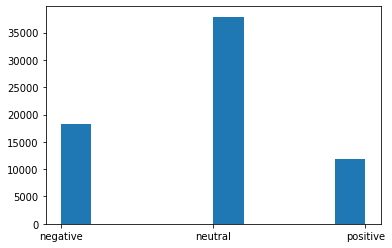

In [ ]:
plt.hist(df_e.sentiment)
plt.show()

Vader's sentiment analyzer is pretty cautious, therefore it is likely not to take extremely polarized values. Consequently, under this splitting of data, the vast majority of tweets are labelled as neutral.

So let's see what happens if the 'neutral' label is removed, letting the sentiments be either 'positive' or 'negative' based, respectively, on positive or negative values of the compound.

In [ ]:
sen = list(np.repeat(1,len(df_e)))
for i in range(len(df_e)):
   if df_e.polarity[i] > 0:
     sen[i] = 'positive'
   else:
    sen[i] = 'negative'

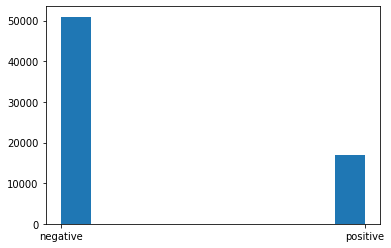

In [ ]:
plt.hist(sen)
plt.show()

In [ ]:
sen = list(np.repeat(1,len(df_e)))
for i in range(len(df_e)):
   if df_e.polarity[i] > 0:
     sen[i] = 'positive'
   else:
    sen[i] = 'negative'

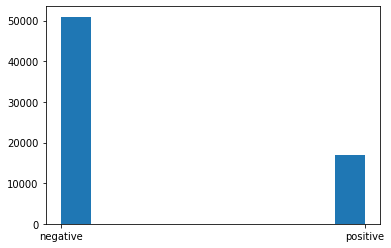

In [ ]:
plt.hist(sen)
plt.show()

With a polarized labelling which doesn't consider the neutral option the difference between negative and positive tweets is clear.

## Preprocessing


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from itertools import chain
from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Text Cleaning**

I created the clean_text function in order to clean the tweets from noisy characters. 

items removed: 
- links
- punctuations/special characters 
- emoticons

Before doing so I also put all the texts in lower case.
I did not remove alphanumeric words to avoid eliminating words like covid19, covid-19 etc.

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https://\S+|www\.\S', '', text)      # remove link
    text = re.sub("['’!@#$%^&*()_+<>?:.,;]" , '', text)  # punctuations/special characters
    text = re.sub("'" , '', text)
    text = re.sub(re.compile("["                        # emoticon
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
                           "]+", flags=re.UNICODE), '', text)
    return text

After being cleaned, each tweet is splitted into single words. 
Therefore, 'words' is a list of lists, where each element is a list of separated strings. 
Now, other pre-processing actions will be performed. 

**Stopwords removal**

What is considered a stopword can be found in the set  below. Such list belongs to the package nltk. 

In [ ]:
stopwords = set(stopwords.words('english')) 
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
def remove_stopwords(text):
    stop = set(stopwords.words('english'))  
    stop.add('im')
    stop.add("i'm")
    stop.add('could')
    stop.add('go')
    stop.add('it')
    stop.add('get')
    stop.add('-')
    stop.add('|')
   # not present in the original set but very recurrent words
    text = [[i for i in i.split() if i not in stop] for i in text]
    return  text

**Lemmatization**

In [ ]:
def lemmatize(text):
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(i, pos = 'v') for i in i] for i in text]
    return text

**Stemming**

In [ ]:
def sb_stem(text):
   stemmer = SnowballStemmer(language = 'english')
   text = [stemmer.stem(i) for i in text]
   return text

In [ ]:
def p_stem(text):
   stemmer = PorterStemmer()
   text = [stemmer.stem(i) for i in text]
   return text

**Final outcome of preprocessing**

In [99]:
def preprocess(text):
  cl_tweets = [clean_text(c) for c in text]
  cl_tweets = pd.Series(cl_tweets).astype(str)
  removed = remove_stopwords(cl_tweets) 
  lemmatized = [lemmatize(i) for i in removed]
  #stemmed = [p_stem(i) for i in lemmatized]
  return lemmatized #stemmed

In [ ]:
from nltk.corpus import stopwords

In [101]:
df_e['tweets'] = preprocess(df_e.tweet)

## Analysis of keywords

Let us now create an even more polarized situation.

Let's take only the most polarized positive and  negative tweets in order to find (if any) differences and similarities in the use of most common words between very positive and very negative tweets.

In [102]:
df_e['polarized_sen'] = np.repeat(1,len(df_e))
for i in range(len(df_e)):
   if df_e.polarity[i] > 0.5:
     df_e['polarized_sen'].loc[i] = 'positive'
   elif df_e.polarity[i] < -0.5:
        df_e['polarized_sen'].loc[i] = 'negative'
   else:
        df_e['polarized_sen'].loc[i] = 'neutral'

In [103]:
from gensim.models import Word2Vec
from matplotlib_venn import venn2

In [104]:
df_e_neg = df_e[df_e.polarized_sen == 'negative'].reset_index()
df_e_pos = df_e[df_e.polarized_sen == 'positive'].reset_index()

In [105]:
neg_w2v = Word2Vec(df_e_neg.tweets, min_count= 400)

In [106]:
pos_w2v = Word2Vec(df_e_pos.tweets, min_count= 200)

In [107]:
n = set(list(neg_w2v.wv.vocab))
p = set(list(pos_w2v.wv.vocab))

set_ebola = n.union(p)

common_elements = n.intersection(p) 

In [108]:
ebola_common_neg = n - n.intersection(p)

In [109]:
ebola_common_pos = p - n.intersection(p)

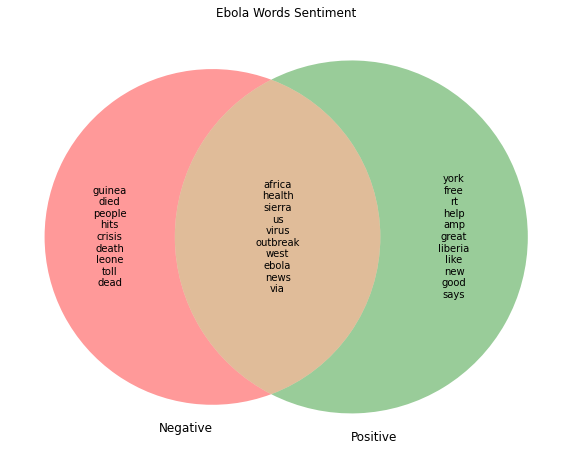

In [110]:
set1 = n
set2 = p

plt.figure(figsize=(10, 10))
venn = venn2([set1, set2], ('Negative','Positive'))
venn.get_label_by_id('100').set_text('\n'.join(set1-set2))
venn.get_label_by_id('110').set_text('\n'.join(set1&set2))
venn.get_label_by_id('010').set_text('\n'.join(set2-set1))
plt.title('Ebola Words Sentiment')
plt.show()

Also, it might be interesting to explore the overall difference in length between positive and negative tweets.

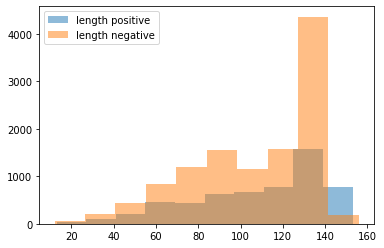

In [111]:
df_e_neg['length'] = [len(i) for i in df_e_neg.tweet]
df_e_pos['length'] = [len(i) for i in df_e_pos.tweet]

plt.hist(df_e_pos.length, label = 'length positive',alpha = 0.5)
plt.hist(df_e_neg.length, label = 'length negative', alpha = 0.5)
plt.legend(loc='upper left')
plt.show()

Both for covid and ebola, there's a pattern showing longer tweets for negative sentiment. This pattern is clear for ebola-related tweets and only slightly confirmed by covid-related ones.

In [112]:
import wordcloud

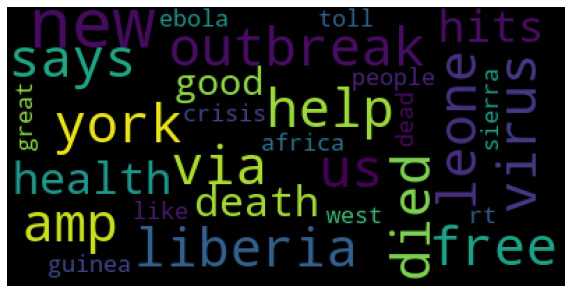

In [113]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=50, stopwords = ['dict_keys', '|'], )
wc = wc.generate(str(",".join(set_ebola)))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wc)
plt.show()

**Word Embedding**

Word Embedding through a Principal Component Analysis model

In [114]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [115]:
ebola_w2v = Word2Vec(df_e.tweets, min_count = 1200)

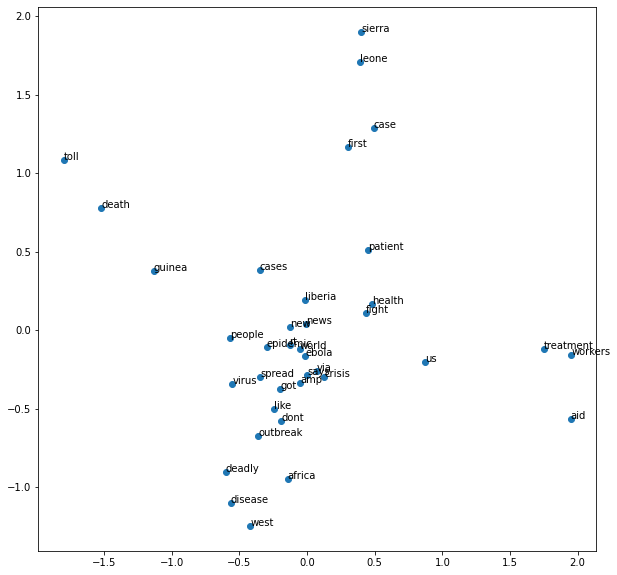

In [116]:
X = ebola_w2v.wv.__getitem__(ebola_w2v.wv.vocab)
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize=(10, 10))
plt.scatter(result[:,0], result[:,1])
words = list(ebola_w2v.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i,0], result[i,1]))
plt.show()

## Introducing more articulated emotions

When dealing with a pandemic event, the distinction of sentiment only based on 'positive', 'negative', or'neutral' sentiment may be restrictive. It might be interesting to investigate more articulated emotions of tweets, and in this section this kind of investigation will be performed.


NRLLex is a package trough which more articulated sentiments can be obtained. In particular, the emotions of:

- Trust
- Fear
- Anticipation
- Anger
- Joy
- Sadness
- Disgust
- Surprise

are recognised and assigned a number from 0 to 1 based on the polarity of the emotion. There may be several emotions representing a tweet, with the sum of ther polarities being equal to 1.

In [ ]:
!pip install NRCLex

In [ ]:
from nrclex import NRCLex
from collections import Counter
nltk.download('punkt')
from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Covid**

Two functions have been created to retrieve the emotions for each tweet.

- getEmotion( ) returns a dictionary where emotions and corresponding frequencies of each tweet are stored.

- EmotionSummary( ) returns a dictionary with the overall sum of frequencies of each emotion.


In [ ]:
def getEmotion(sentence):
  emotion = NRCLex(sentence) 
  a_l = emotion.affect_frequencies
  return a_l

def EmotionSummary(list):
  emotions = [getEmotion(i) for i in list]
  c = Counter()
  for d in emotions:
    c.update(d)
  c = dict(c)
  c = dict(sorted(c.items(), key=lambda item: item[1], reverse=True))
  c.pop('negative')   
  c.pop('positive')
  c.pop('anticip')
  return c

In [ ]:
ebola_emotion_sum = EmotionSummary(df_e.tweet)

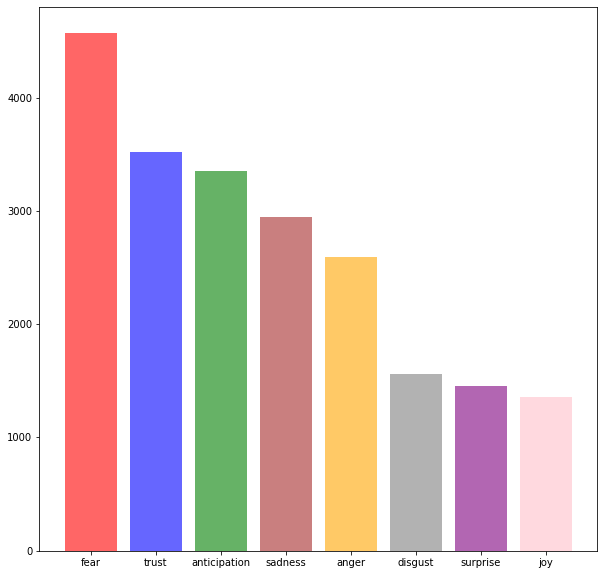

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(ebola_emotion_sum.keys(), ebola_emotion_sum.values(), color = ['red','blue', 'green', 'brown', 'orange','grey','purple', 'pink'], alpha = 0.6)
plt.show()

For ebola analysis data haven't been divided into periods but only general emotion analysis has been computed. 

In this case, fear is clearly the most present sentiment, followed by trust, anticipation and sadness. 

The first five emotions, regardless the rank, are the same both for ebola and covid and might be considered the 5 emotions associated with a pandemic outbreak.

## Download results

In [125]:
df_e.to_csv('df_e_ext.csv')

## References

- Xue, J., Chen, J., Hu, R., Chen, C., Zheng, C., Su, Y., Zhu, T., *Twitter Discussions and Emotions About the COVID-19 Pandemic: Machine Learning Approach*, J Med Internet Res. 2020 Nov 25;22(11):e20550. doi: 10.2196/20550. PMID: 33119535; PMCID: PMC7690968. 

- Liang, H., Fung, I.CH., Tse, Z.T.H. et al., 2019, *How did Ebola information spread on twitter: broadcasting or viral spreading?*, BMC Public Health 19, 438 (2019). https://doi.org/10.1186/s12889-019-6747-8 

- VanderPlas, J., 2016, *Python Data Science Handbook: Essential Tools for Working with Data*, O'Reilly. 

